In [ ]:
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
import random, shutil
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
import itertools
from keras.layers import (
    Dropout,
    Conv2D,
    Flatten,
    Dense,
    MaxPooling2D,
    BatchNormalization,
)
from keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
import visualkeras

import os
import shutil
import glob
from tqdm import tqdm
import random
import plotly.express as px
import pandas

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout,Input,Flatten,Dense,MaxPooling2D ,AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img # Data Augumentation

Create Dataset folder

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

In [ ]:
!unzip gdrive/MyDrive/mrlEyes_2018_01.zip

unzip:  cannot find or open gdrive/MyDrive/mrlEyes_2018_01.zip, gdrive/MyDrive/mrlEyes_2018_01.zip.zip or gdrive/MyDrive/mrlEyes_2018_01.zip.ZIP.


In [ ]:
def creat(path):     
    try: 
        os.mkdir(path) 
    except OSError as error: 
        print(error)

In [ ]:
path = 'DDS Dataset'

creat(path)


path = 'DDS Dataset/data'
creat(path)

path_train = path+"/train"
creat(path_train)

path_test = path+"/test"
creat(path_test)

path_open = path_train+"/Open"
creat(path_open)    

path_open = path_test+"/Open"
creat(path_open)    

path_close =  path_test+"/Closed"
creat(path_close)

path_close =path_train+"/Closed"
creat(path_close)

In [ ]:
path='../content/mrlEyes_2018_01'
path2="./DDS Dataset/data"

In [ ]:
for dirpath, dirname, filenames in os.walk(path):
    for i in tqdm([f for f in filenames if f.endswith('.png')]):
        if i.split('_')[4]=='0':
            shutil.copy(src=dirpath+'/'+i, dst=path2+'/train/Closed')
        
        elif i.split('_')[4]=='1':
            shutil.copy(src=dirpath+'/'+i, dst=path2+'/train/Open')

**Image Classification based on Open and closed Eye**

In [ ]:
def create_test_closed(source, destination, percent):
    '''
    divides closed eyes images into given percent and moves from
    source to destination.
    
    Arguments:
    source(path): path of source directory
    destination(path): path of destination directory
    percent(float): percent of data to be divided(range: 0 to 1)
    '''
    path, dirs, files_closed = next(os.walk(source))
    file_count_closed = len(files_closed)
    percentage = file_count_closed * percent
    to_move = random.sample(glob.glob(source + "/*.png"), int(percentage))

    for f in enumerate(to_move):
        if not os.path.exists(destination):
            os.makedirs(destination)
        shutil.move(f[1], destination)
    print(f'moved {int(percentage)} images to the destination successfully.')  


def create_test_open(source, destination, percent):
    '''
    divides open eyes images into given percent and moves from
    source to destination.
    
    Arguments:
    source(path): path of source directory
    destination(path): path of destination directory
    percent(float): percent of data to be divided(range: 0 to 1)
    '''
    path, dirs, files_open = next(os.walk(source))
    file_count_open = len(files_open)
    percentage = file_count_open * percent
    to_move = random.sample(glob.glob(source + "/*.png"), int(percentage))

    for f in enumerate(to_move):
        if not os.path.exists(destination):
            os.makedirs(destination)
        shutil.move(f[1], destination)
    print(f'moved {int(percentage)} images to the destination successfully.')

In [ ]:
create_test_closed(path2+'/train/Closed', 
                    path2+'/test/Closed', 
                    0.2)

moved 0 images to the destination successfully.


In [ ]:
create_test_open(path2+'/train/Open', 
                path2+'/test/Open', 
                    0.2)

moved 0 images to the destination successfully.


In [ ]:
def walk_data(mydict, folder_path):
    for (root,dirs,files) in os.walk(folder_path, topdown=False):
        if len(files)>0:
            mydict[root]=len(files)

In [ ]:
train_dict = dict()
test_dict = dict()
walk_data(train_dict,path2+"/train/")
walk_data(test_dict, path2+"/test/")

In [ ]:
def fix_keys(mydict,typ):
    new_dict = dict()
    for k, v in mydict.items():
        new_k = k.split('/')[-1]
        new_dict[new_k+" "+typ] = v
    return new_dict

In [ ]:
train_dict = fix_keys(train_dict,'train')
test_dict = fix_keys(test_dict,'test')
print(train_dict)
print(test_dict)

{}
{}


In [ ]:
label_train_dict = {'Expressions':train_dict.keys(), 'Count':train_dict.values}
label_val_dict = {'Expressions':test_dict.keys(), 'Count':test_dict.values}

In [ ]:
def plot_dist(my_dict, data):
    fig = px.bar(x=my_dict.values(),
             y=my_dict.keys(),
             orientation='h',
             color=my_dict.values(),
             title=data + ' Distribution',
             opacity=0.8,
             color_discrete_sequence=px.colors.diverging.curl,
             template='plotly_dark'
            )
    fig.update_xaxes()
    fig.show()

In [ ]:
dict={**test_dict, **train_dict}
print(dict)

{}


In [ ]:
plot_dist(dict, "Data")

ValueError: ignored

**Model Architecture using InceptionV3**

In [ ]:
# Training data

train_datagen= image.ImageDataGenerator(rescale=1./255, rotation_range=0.2,shear_range=0.2,zoom_range=0.2, width_shift_range=0.2,
                                        height_shift_range=0.2,validation_split=0.2)
# Split 20% of training data  to validation data
train_data= train_datagen.flow_from_directory(path2+"/train",
                                              class_mode = 'categorical',
                                              target_size=(80,80),
                                              batch_size=4,subset='training'
                                              )

Validation_data= train_datagen.flow_from_directory(path2+"/train",
                                            class_mode="categorical",
                                            target_size=(80,80),
                                            batch_size=4,subset='validation')   

Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
bmodel = InceptionV3(include_top=False, weights='imagenet', input_tensor=Input(shape=(80,80,3)))
hmodel = bmodel.output

hmodel = Flatten()(hmodel)
hmodel = Dense(64, activation = 'relu')(hmodel)
hmodel = Dropout(0.5)(hmodel)
hmodel = Dense(2,activation = 'softmax')(hmodel)

model = Model(inputs=bmodel.input, outputs= hmodel)
for layer in bmodel.layers:
    layer.trainable = False

In [ ]:
checkpoint = ModelCheckpoint('DDS Dataset/data/premodel.h5',
                            monitor='val_loss',save_best_only=True,verbose=3)
earlystop = EarlyStopping(monitor = 'val_loss', patience=3, verbose=0, restore_best_weights=True)

learning_rate = ReduceLROnPlateau(monitor= 'val_loss', patience=3, verbose=0)

callbacks=[checkpoint,earlystop,learning_rate]

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history_=model.fit(train_data,
                    steps_per_epoch=train_data.n//train_data.batch_size,
                    validation_data=Validation_data,
                    validation_steps=Validation_data.n//Validation_data.batch_size,
                    callbacks=callbacks,
                    epochs=10)

ValueError: ignored

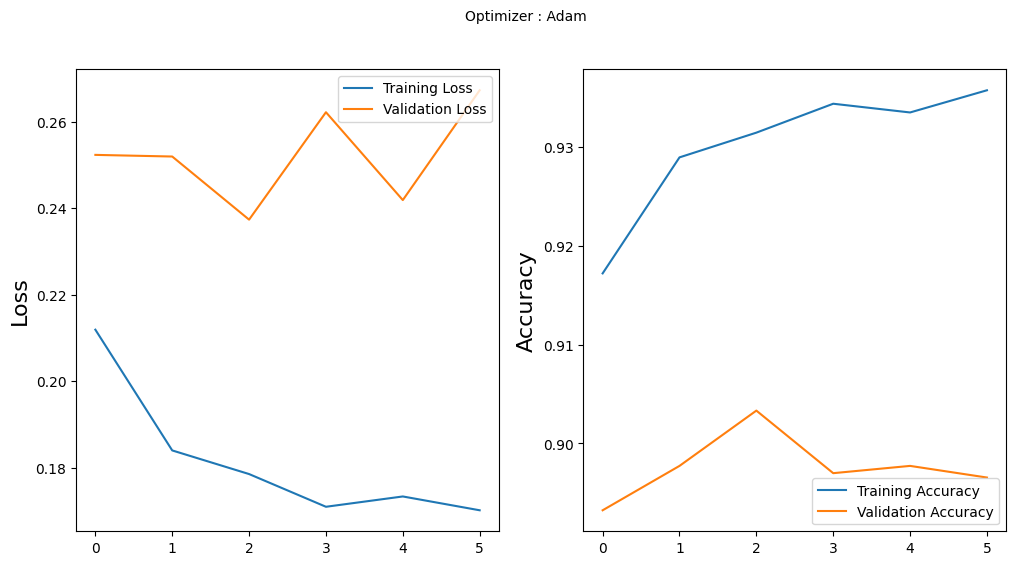

In [ ]:
premodel_history=history_.history
plt.style.use('default')

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(premodel_history['loss'], label='Training Loss')
plt.plot(premodel_history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(premodel_history['accuracy'], label='Training Accuracy')
plt.plot(premodel_history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

**Evaluate the model**

In [ ]:
model=load_model('./DDS Dataset/data/premodel.h5')
model.save('./DDS Dataset/data/premodel.h5')

In [ ]:
test_datagen= image.ImageDataGenerator(rescale=1./255)

test_data= test_datagen.flow_from_directory("../content/DDS Dataset/data/test",
                                            class_mode="categorical",
                                            classes=["Closed","Open"],
                                            shuffle=False,
                                            target_size=(80,80),
                                            batch_size=4,
                                            )

Found 16979 images belonging to 2 classes.


In [ ]:
predictions = model.predict(test_data)

4245/4245 [==============================] - 297s 70ms/step


In [ ]:
from sklearn.metrics import classification_report
import numpy 
# predicted_classes =  np.where(predictions>0.5, 1, 0)
# true_classes = test_data.classes
# class_labels = list(test_data.class_indices.keys())   
# report=classification_report(true_classes, predicted_classes, target_names=class_labels)
# print(report)

predicted_classes = np.argmax(predicted_classes, axis=1) 
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())   
report=classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      Closed       0.92      0.97      0.94      8389
        Open       0.97      0.91      0.94      8590

    accuracy                           0.94     16979
   macro avg       0.94      0.94      0.94     16979
weighted avg       0.94      0.94      0.94     16979



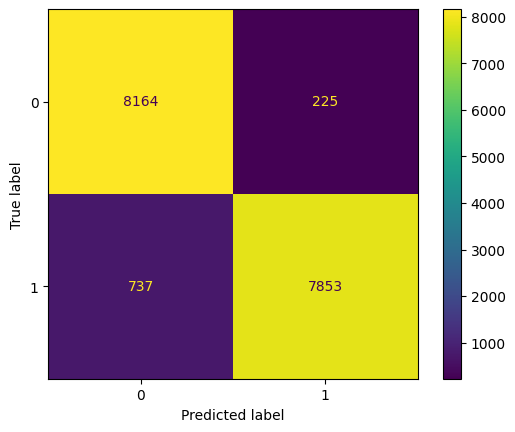

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            )
disp.plot()
plt.show()

***Final Output***

In [11]:
from google.colab import files

In [12]:
from IPython import display


In [13]:
uploaded= files.upload()

Saving output 3 (1).png to output 3 (1).png
Saving output 3 (2).png to output 3 (2).png
Saving output 3 (3).png to output 3 (3).png


**Eye Blinking Status vs Time**

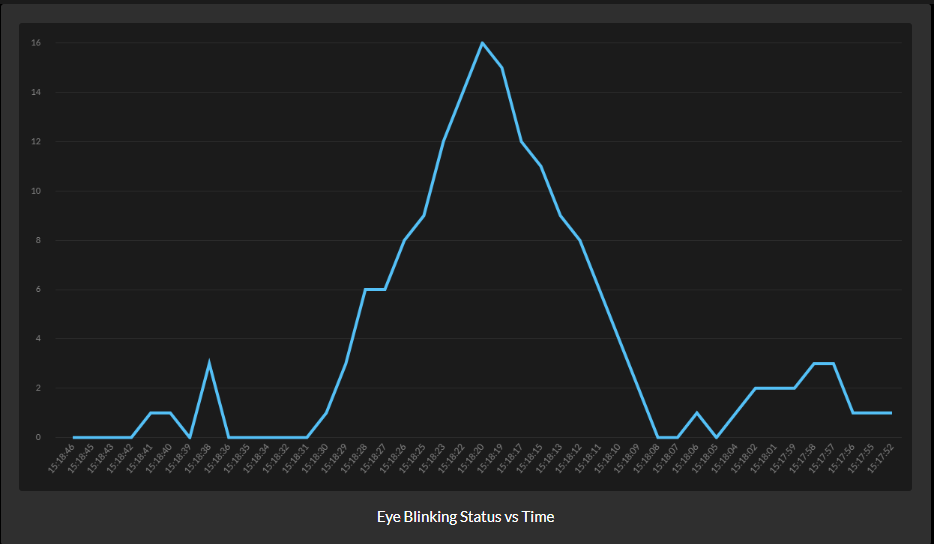

In [16]:
display.Image('output 3 (3).png')

**2. Blink COunt**

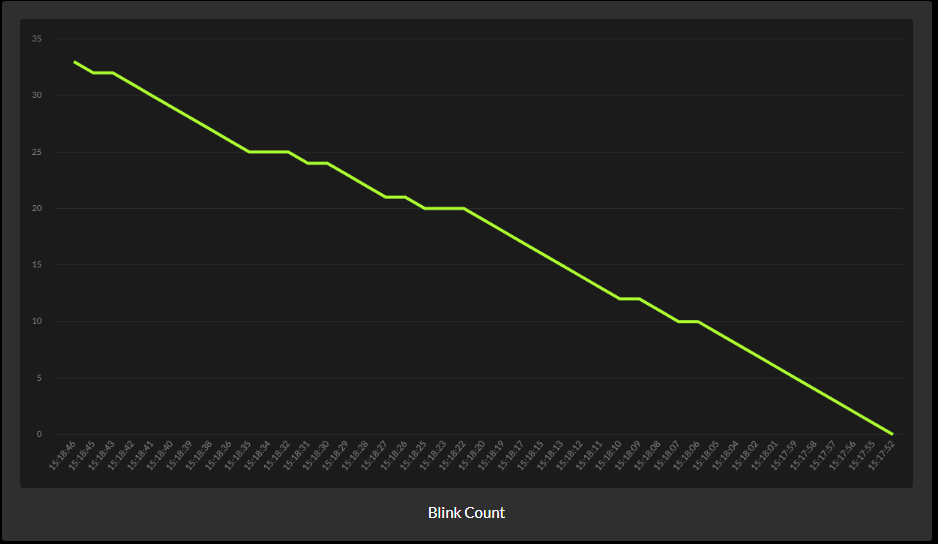

In [15]:
display.Image('output 3 (2).png')

**3.Alarm Duration**

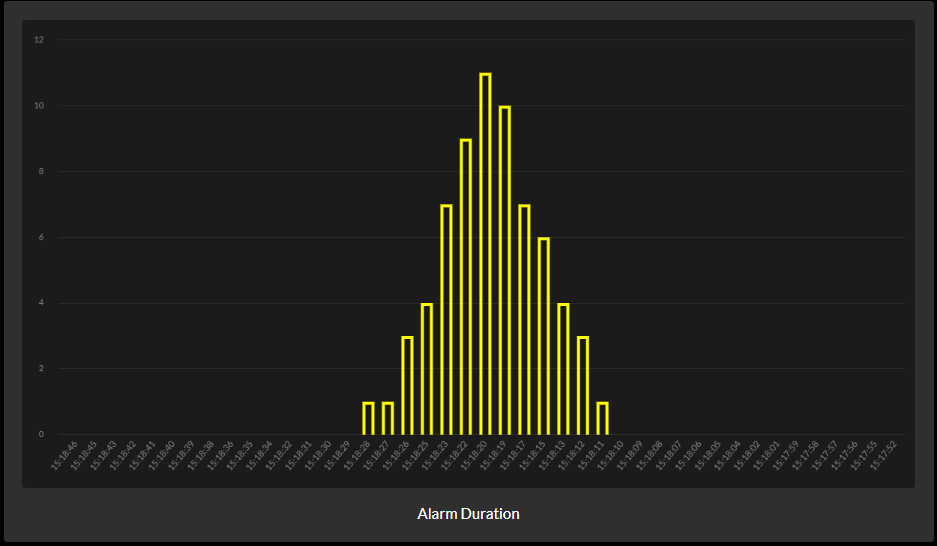

In [17]:
display.Image('output 3 (1).png')

***Premodel predicted Output***

In [18]:
uploaded= files.upload()

Saving model output (1).png to model output (1).png
Saving model output (2).png to model output (2).png


**1.Open Eye**

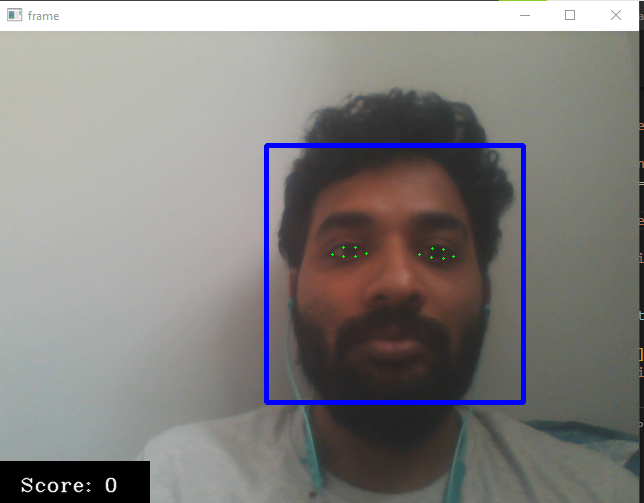

In [22]:
display.Image('model output (2).png')

**2. Closed Eye with ALarm**

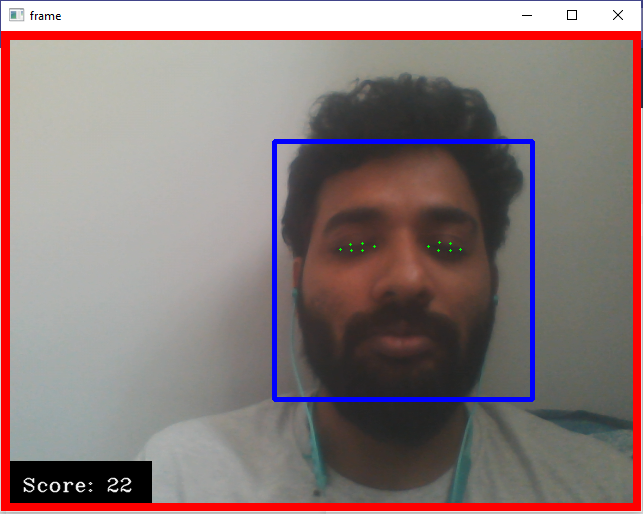

In [21]:
display.Image('model output (1).png')